## ディープニューラルネットワークスクラッチ



前回は3層のニューラルネットワークを作成しましたが、今回はこれを任意の層数に拡張しやすいものに書き換えていきます。その上で、活性化関数や初期値、最適化手法について発展的なものを扱えるようにしていきます。


このようなスクラッチを行うことで、今後各種フレームワークを利用していくにあたり、内部の動きが想像できることを目指します。


名前は新しくScratchDeepNeuralNetrowkClassifierクラスとしてください。


層などのクラス化  
クラスにまとめて行くことで、構成を変更しやすい実装にしていきます。


手を加える箇所

- 層の数
- 層の種類（今後畳み込み層など他のタイプの層が登場する）
- 活性化関数の種類
- 重みやバイアスの初期化方法
- 最適化手法

そのために、全結合層、各種活性化関数、重みやバイアスの初期化、最適化手法それぞれのクラスを作成します。


実装方法は自由ですが、簡単な例を紹介します。サンプルコード1のように全結合層と活性化関数のインスタンスを作成し、サンプルコード2,3のようにして使用します。それぞれのクラスについてはこのあと解説します。



### 【問題1】全結合層のクラス化
全結合層のクラス化を行なってください。


以下に雛形を載せました。コンストラクタで重みやバイアスの初期化をして、あとはフォワードとバックワードのメソッドを用意します。重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要になります。


なお、インスタンスも引数として渡すことができます。そのため、初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われます。渡すインスタンスを変えれば、初期化方法が変えられます。


また、引数として自身のインスタンスselfを渡すこともできます。これを利用してself.optimizer.update(self)という風に層の重みの更新が可能です。更新に必要な値は複数ありますが、全て全結合層が持つインスタンス変数にすることができます。


初期化方法と最適化手法のクラスについては後述します。

In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [22]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [23]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(y_train.shape)
print(y_test.shape)
print(X_train[0].dtype) # uint8
print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)
uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   

In [24]:
X_train = X_train.reshape(-1 , 784)#(60000, 784)
X_test = X_test.reshape(-1 , 784)#(10000, 784)

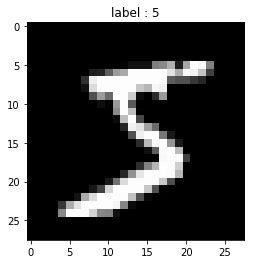

In [25]:
index = 0
image = X_train[index].reshape(28 , 28)
#X_train[index] : (784,)
#image : (28,28)
plt.imshow(image , "gray")
plt.title("label : {}".format(y_train[index]))
plt.show()

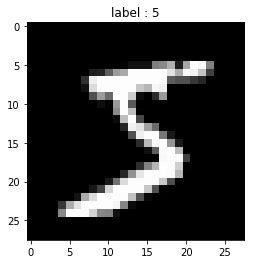

[[-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -1

In [26]:
index = 0
image = X_train[index].reshape(28,28)
image = image.astype(np.float)#float型に変換
image -= 105.35 #意図的に負の小数値を作り出してみる
plt.imshow(image , "gray")
plt.title("label : {}".format(y_train[index]))
plt.show()
print(image)#値を確認

In [27]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max())#1.0
print(X_train.min())#0.0

1.0
0.0


In [28]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [29]:
from sklearn.model_selection import train_test_split
X_train , X_val , y_train , y_val = train_test_split(
             X_train , y_train_one_hot , test_size = 0.20)
print(X_train.shape)
print(X_val.shape)

(48000, 784)
(12000, 784)


In [30]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [31]:
get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)

for mini_X_train, mini_y_train in get_mini_batch:
    # このfor文内でミニバッチが使える
    pass

In [32]:
batch_size = 20 # バッチサイズ
n_features = X_train.shape[1] # 特徴量の数
n_nodes1 = 400 # 1層目のノード数
n_nodes2 = 200 # 2層目のノード数
n_output = 10 # 出力のクラス数（3層目のノード数）
sigma = 0.01 # ガウス分布の標準偏差

In [33]:
def _sigmoid(self , a):
        c = np.max(a)
        return 1 / (1 + np.exp(-(a/c)))

In [34]:
def initial_value(n_features , n_nodes1,n_nodes2, n_output , sigma):
    W1 = sigma * np.random.rand(n_features , n_nodes1)#一層目の重み
    W2 = sigma * np.random.rand(n_nodes1 , n_nodes2)#二層目の重み
    W_out = sigma * np.random.rand(n_nodes2 , n_output)#出力層の重み
    b1 = np.zeros(n_nodes1)#一層目のバイアス
    b2 = np.zeros(n_nodes2)#二層目のバイアス
    b_out = np.zeros(n_output)#出力層のバイアス
    return W1,W2,W_out,b1,b2,b_out

In [35]:
W1 , W2 , W_out , b1 , b2 , b_out = initial_value(n_features , n_nodes1,n_nodes2, n_output , sigma)

In [36]:
get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)

# print(len(get_mini_batch)) # 2400
# print(get_mini_batch[5]) # 5番目のミニバッチが取得できる
for mini_X_train, mini_y_train in get_mini_batch:
    A1 = np.dot(mini_X_train , W1) + b1
    Z1 = np.tanh(A1)
    A2 = np.dot(Z1 , W2) + b2
    Z2 = np.tanh(A2)
    A3 = np.dot(Z2 , W_out) + b_out
    Z3 = Z = np.exp(A3) / np.sum(np.exp(A3))
    L = -np.sum(mini_y_train * np.log(Z3)) / batch_size

やること？
- initializerのメソッドを使い、self.Wとself.Bを初期化する

In [37]:
class FC():
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer , sigma=0.01):
        self.optimizer = optimizer
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.initializer = initializer
        self.sigma = sigma
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = self.initializer.W(self.n_nodes1 , self.n_nodes2)
        self.B = self.initializer.B(self.n_nodes2)
        self.X = None
        self.dW = None
        self.dB = None
        self.hw = 0
        self.hb = 0
        
        
        
#         self.W = self.sigma * self.initializer.W(self.n_nodes1 , self.n_nodes2)
#         self.B = self.sigma * self.initializer.B(self.n_nodes2)
#         self.W2 = self.sigma * self.initializer.W(self.n_nodes1 , self.n_nodes2)
#         self.B2 = self.initializer.B(self.n_nodes2)
#         self.W_out = self.sigma * self.initializer.W(self.n_nodes2 , self.n_output)
#         self.B_out = self.initializer.B(self.n_output)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """   
        self.X = X
        self.A = np.dot(self.X , self.W) + self.B
        
        return self.A
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        self.dW = np.dot(self.X.T , dA)
        self.dB = np.sum(dA , axis = 0)
        dZ = np.dot(dA , self.W.T)
        # 更新
        self = self.optimizer.update(self)
        return dZ

 ### 【問題2】初期化方法のクラス化
初期化を行うコードをクラス化してください。


前述のように、全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにします。以下の雛形に必要なコードを書き加えていってください。標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになります。


これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにします。



In [38]:
class SimpleInitializer():
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, n_nodes1, n_nodes2):
        W = self.sigma * np.random.randn(n_nodes1 , n_nodes2)
        
        return W
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B
 

【問題3】最適化手法のクラス化
最適化手法のクラス化を行なってください。


最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡します。バックワードのときにself.optimizer.update(self)のように更新できるようにします。以下の雛形に必要なコードを書き加えていってください。


これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成します。

In [39]:
class SGD():
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
#         layer.W = self.W
#         layer.B = self.B
#         layer.dW = self.dW
#         layer.dB = self.dB
        
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return layer.W , layer.B

### 【問題4】活性化関数のクラス化
活性化関数のクラス化を行なってください。


ソフトマックス関数のバックプロパゲーションには交差エントロピー誤差の計算も含む実装を行うことで計算が簡略化されます。



In [40]:
class SoftmaxWithLoss():
    def __init__(self):
        self.loss = None
        self.y = None
        
        
    def forward(self , x):
        if x.ndim == 2:
            x = x.T
            x = x - np.max(x, axis=0)
            y = np.exp(x) / np.sum(np.exp(x), axis=0)
            return y.T
        x = x - np.max(x)
        return np.exp(x) / np.sum(np.exp(x))
    
    def backward(self , z , y):
        self.dA = z - y
        return self.dA
    
    def Loss(self , z , y):
        loss =  -np.sum(y * np.log(z) + 1e-7) / y.shape[0]
        return loss

In [41]:
class _sigmoid():
    def __init__(self):
        self.sig = None
    
    def forward(self , x):
        c = np.max(x)
        x = x / c
        self.sig = 1 / (1 +  np.exp(-x))
        return self.sig
    
    def backward(self , x):
        self.dA = x * (1 - self.sig) * self.sig
        return self.dA

### 【問題5】ReLUクラスの作成
現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装してください。


ReLUは以下の数式です。
$$
% <![CDATA[
f(x) = ReLU(x) = \begin{cases}
x  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases} %]]>
$$

x
 : ある特徴量。スカラー


実装上はnp.maximumを使い配列に対してまとめて計算が可能です。


numpy.maximum — NumPy v1.15 Manual


一方、バックプロパゲーションのための 
x
 に関する 
f
(
x
)
 の微分は以下のようになります。
 
 $$
 % <![CDATA[
\frac{\partial f(x)}{\partial x} = \begin{cases}
1  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases} %]]>
$$

数学的には微分可能ではないですが、 
x
=
0
 のとき 
0
 とすることで対応しています。


フォワード時の 
x
 の正負により、勾配を逆伝播するかどうかが決まるということになります。

In [42]:
class ReLU():
    def __init__(self):
        self.mask = None
        
    def forward(self , x):
        self.mask = (x <= 0)
        self.A = x.copy()
        self.A[self.mask] = 0
        return self.A
        
    def backward(self , dA):
        dA[self.mask] = 0
        dA = dA
        return dA

### 【問題6】重みの初期値
ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。しかし、どのような値にすると良いかが知られています。シグモイド関数やハイパボリックタンジェント関数のときは Xavierの初期値 （またはGlorotの初期値）、ReLUのときは Heの初期値 が使われます。


XavierInitializerクラスと、HeInitializerクラスを作成してください。


Xavierの初期値
Xavierの初期値における標準偏差 
σ
 は次の式で求められます。


σ
=
1
√
n

n
 : 前の層のノード数


《論文》


Glorot, X., & Bengio, Y. (n.d.). Understanding the difficulty of training deep feedforward neural networks.


Heの初期値
Heの初期値における標準偏差 
σ
 は次の式で求められます。


σ
=
√
2
n

n
 : 前の層のノード数


《論文》


He, K., Zhang, X., Ren, S., & Sun, J. (2015). Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification.



In [43]:
class XavierInitializer():
    def __init__(self, n_nodes1,n_nodes2):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2        
    
    def W(self):
        sigma = np.sqrt(1.0 / self.n_nodes1)
        self.W = sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        return self.W
    
    def B(self):
        sigma = np.sqrt(1.0 / self.n_nodes1)
        self.B = sigma * np.random.randn(self.n_nodes2)
        return self.B

In [44]:
class HeInitializer():
    def __init__(self,n_nodes1,n_nodes2):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
    
    def W(self):
        sigma =  np.sqrt(2.0 / n_nodes1)
        self.W = sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        return self.W
    
    def B(self):
        sigma =  np.sqrt(2.0 / n_nodes1)
        self.W = sigma * np.random.randn(self.n_nodes2)
        return self.B

In [45]:
#Heの初期値
w = np.random.randn(n_nodes1, n_nodes2) * np.sqrt(2.0 / n_nodes1)

In [46]:
#Xavierの初期値
w = np.random.randn(n_nodes1, n_nodes2) * np.sqrt(1.0 / n_nodes1)

【問題7】最適化手法
学習率は学習過程で変化させていく方法が一般的です。基本的な手法である AdaGrad のクラスを作成してください。


まず、これまで使ってきたSGDを確認します。
$$
W_i^{\prime} = W_i - \alpha E(\frac{\partial L}{\partial W_i}) \\<br/>B_i^{\prime} = B_i - \alpha E(\frac{\partial L}{\partial B_i})
$$
α
 : 学習率（層ごとに変えることも可能だが、基本的には全て同じとする）


∂
L
∂
W
i
 : 
W
i
 に関する損失 
L
 の勾配


∂
L
∂
B
i
 : 
B
i
 に関する損失 
L
 の勾配


E
(
)
 : ミニバッチ方向にベクトルの平均を計算


続いて、AdaGradです。バイアスの数式は省略しますが、重みと同様のことをします。


更新された分だけその重みに対する学習率を徐々に下げていきます。イテレーションごとの勾配の二乗和 
H
 を保存しておき、その分だけ学習率を小さくします。


学習率は重み一つひとつに対して異なることになります。



$$
H_i^{\prime}  = H_i+E(\frac{\partial L}{\partial W_i})×E(\frac{\partial L}{\partial W_i})\\<br/>W_i^{\prime} = W_i - \alpha \frac{1}{\sqrt{H_i^{\prime} }} E(\frac{\partial L}{\partial W_i}) \\
$$
H
i
 : i層目に関して、前のイテレーションまでの勾配の二乗和（初期値は0）


H
′
i
 : 更新した 
H
i

《論文》


Duchi JDUCHI, J., & Singer, Y. (2011). Adaptive Subgradient Methods for Online Learning and Stochastic Optimization * Elad Hazan. Journal of Machine Learning Research (Vol. 12).




In [47]:
class AdaGrad():
    def __init__(self , lr , b_size):
        self.lr = lr
        self.hw = None
        self.hb = None
        self.b_size = b_size
    
    def update(self , layer):
#         layer.W = self.W
#         layer.B = self.B
#         layer.dW = self.dW
#         layer.dB = self.dB
        
        layer.hw += (layer.dW/self.b_size) * (layer.dW/self.b_size)
        layer.W -= self.lr * (layer.dW/self.b_size) / (np.sqrt(layer.hw) + 1e-7)
        layer.hb += (layer.dB/self.b_size) * (layer.dB/self.b_size)
        layer.B -= self.lr * (layer.dB/self.b_size) / (np.sqrt(layer.hb) + 1e-7)
        self.hw = layer.hw
        self.hb = layer.hb
        return layer.W, layer.B

### 【問題8】クラスの完成
任意の構成で学習と推定が行えるScratchDeepNeuralNetrowkClassifierクラスを完成させてください。

In [48]:
class ScratchDeepNeuralNetrowkClassifier():

    def __init__(self,epochs = 1,lr = 0.001 ,sigma = 0.01,n_nodes1= 400 , n_nodes2 = 200 , n_output = 10 , batch_size = 20, verbose = True):
        self.verbose = verbose
        self.sigma = sigma
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        n_features = X_train.shape[1]
        self.n_features = n_features
        self.batch_size = batch_size
        self.lr = lr
        self.loss = []
        self.epochs = epochs


    def fit(self, X, y, X_val=None, y_val=None):
   
        Xavi = HeInitializer(self.n_nodes1 , self.n_nodes2)
        self.W = Xavi.W()
        self.B = Xavi.B()
        optimizer = AdaGrad(self.lr , self.batch_size)
        self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
        self.activation1 = ReLU()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
        self.activation2 = ReLU()
        self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
        self.activation3 = SoftmaxWithLoss()
        
        for i in range(self.epochs):
            self.get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)
            for self.mini_X_train, self.mini_y_train in get_mini_batch:
                A1 = self.FC1.forward(self.mini_X_train)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                
                dA3 = self.activation3.backward(Z3 , self.mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
#                 dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
                self.c_loss = self.activation3.Loss(Z3 , self.mini_y_train)
            self.loss = np.append(self.loss , self.c_loss)
        
        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print(self.W)

    def _predict(self, X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
#         Z3 = self.activation3.forward(A3)
#         A4 = self.FC4.forward(Z3)
#         Z4 = self.activation4.forward(A4)
#         A5 = self.FC5.forward(Z4)
        Z3 = self.activation3.forward(A3)
        self.y_pred = np.argmax(Z3 , axis = 1)
        return self.y_pred
    
    def accuracy(self , X , t):
        y_pred = self._predict(X)
        return np.sum(y_pred == t) / float(X.shape[0])

### 【問題9】学習と推定
層の数や活性化関数を変えたいくつかのネットワークを作成してください。そして、MNISTのデータを学習・推定し、Accuracyを計算してください。

In [49]:
dnn = ScratchDeepNeuralNetrowkClassifier(epochs = 10 , lr = 1e-3)

In [50]:
dnn.fit(X_train , y_train)

[[-0.08900015 -0.08898247 -0.02015056 ... -0.0036665   0.10204279
  -0.03095126]
 [ 0.00158414  0.0571258  -0.02655313 ...  0.01380231 -0.05624698
  -0.00316739]
 [ 0.02441896 -0.03077423  0.01564676 ...  0.05406871 -0.07849301
   0.13839742]
 ...
 [ 0.08122608  0.11368571  0.04495892 ... -0.00941898 -0.02449655
  -0.09533314]
 [-0.07418259  0.00675893 -0.04129853 ...  0.11024035 -0.0374091
   0.11809454]
 [-0.04050309  0.00492686  0.08520224 ...  0.08050452 -0.04943802
  -0.09090019]]


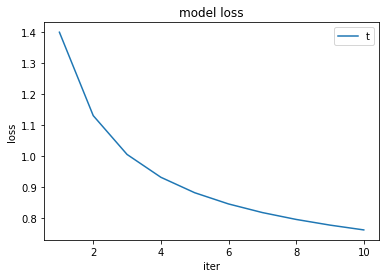

In [51]:
plt.plot(np.arange(1 , len(dnn.loss) + 1) , dnn.loss , label = "loss")
# plt.plot(np.arange(1 , len(slr.val_loss) + 1) , slr.val_loss , label = "test_loss")
plt.title("model loss")
plt.xlabel("iter")
plt.ylabel("loss")
plt.legend("train_loss")
plt.show()

In [52]:
dnn.accuracy(X_test , y_test)

0.8431

In [53]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [54]:
dnn._predict(X_val)

array([3, 4, 6, ..., 5, 2, 5])

In [55]:
dnn.loss

array([1.40073067, 1.13062797, 1.00491999, 0.93094726, 0.88092642,
       0.84459979, 0.81669091, 0.79441059, 0.77603583, 0.76045839])

In [56]:
class ScratchDeepNeuralNetrowkClassifier():

    def __init__(self,epochs = 1,lr = 0.001 ,sigma = 0.01,n_nodes1= 400 , n_nodes2 = 300 ,n_nodes3=200 , n_nodes4=100, n_output = 10 , batch_size = 20, verbose = True):
        self.verbose = verbose
        self.sigma = sigma
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_nodes3 = n_nodes3
        self.n_nodes4 = n_nodes4
        self.n_output = n_output
        n_features = X_train.shape[1]
        self.n_features = n_features
        self.batch_size = batch_size
        self.lr = lr
        self.loss = []
        self.epochs = epochs


    def fit(self, X, y, X_val=None, y_val=None):
   
        Xavi = HeInitializer(self.n_nodes1 , self.n_nodes2)
        self.W = Xavi.W()
        self.B = Xavi.B()
        optimizer = AdaGrad(self.lr , self.batch_size)
        self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
        self.activation1 = ReLU()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
        self.activation2 = ReLU()
        self.FC3 = FC(self.n_nodes2, self.n_nodes3, SimpleInitializer(self.sigma), optimizer)
        self.activation3 = ReLU()
        self.FC4 = FC(self.n_nodes3, self.n_nodes4, SimpleInitializer(self.sigma), optimizer)
        self.activation4 = ReLU()
        self.FC5= FC(self.n_nodes4, self.n_output, SimpleInitializer(self.sigma), optimizer)
        self.activation5 = SoftmaxWithLoss()
        
        for i in range(self.epochs):
            self.get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)
            for self.mini_X_train, self.mini_y_train in get_mini_batch:

                A1 = self.FC1.forward(self.mini_X_train)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                A4 = self.FC4.forward(Z3)
                Z4 = self.activation4.forward(A4)
                A5 = self.FC5.forward(Z4)
                Z5 = self.activation5.forward(A5)
                
                dA5 = self.activation5.backward(Z5 , self.mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ4 = self.FC5.backward(dA5)                
                dA4 = self.activation4.backward(dZ4)
                dZ3 = self.FC4.backward(dA4)                
                dA3 = self.activation3.backward(dZ3)
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
#                 dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
                self.c_loss = self.activation5.Loss(Z5 , self.mini_y_train)
            self.loss = np.append(self.loss , self.c_loss)
        
        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print()

    def _predict(self, X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        A4 = self.FC4.forward(Z3)
        Z4 = self.activation4.forward(A4)
        A5 = self.FC5.forward(Z4)
        Z5 = self.activation5.forward(A5)
        self.y_pred = np.argmax(Z5 , axis = 1)
        return self.y_pred
    
    def accuracy(self , X , t):
        y_pred = self._predict(X)
        return np.sum(y_pred == t) / float(X.shape[0])

In [57]:
dnn = ScratchDeepNeuralNetrowkClassifier(epochs = 10 , lr = 1e-1)

In [58]:
dnn.fit(X_train , y_train)

In [59]:
dnn._predict(X_val)

array([3, 4, 5, ..., 5, 2, 3])

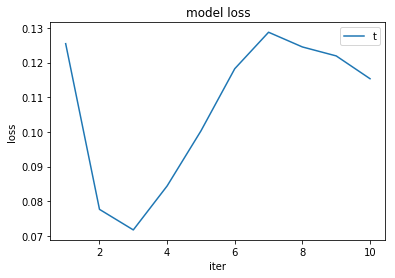

In [60]:
plt.plot(np.arange(1 , len(dnn.loss) + 1) , dnn.loss , label = "loss")
# plt.plot(np.arange(1 , len(slr.val_loss) + 1) , slr.val_loss , label = "test_loss")
plt.title("model loss")
plt.xlabel("iter")
plt.ylabel("loss")
plt.legend("train_loss")
plt.show()

In [61]:
dnn.accuracy(X_test , y_test)

0.9596